# INTRODUCTION

In the following cells we introduce some relevant quantities (current price, dividend yield, volatility, etc.) for the selected stock (Pfizer) and we define some custom functions (Black & Scholes, greek's computations, etc.)

In [20]:
#import useful packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm
from math import *
from tqdm import tqdm


In [21]:
#define variables for our stock (Pfizer), according to market ressearch

S0 = 26.93               # stock price as of February 2nd
sigma = 0.2443           # implied volatility assumed from past data
r_st = 0.0523            # annualized risk-free rate according to T-Bill 1M
r_lt = 0.0534            # annualized risk-free rate according to T-Bill 3M
q = 0.0609               # dividend yield (Yahoo Finance)

r = r_st
T = 7/365                # 1 year time period
K = S0                   # assuming strike price equal stock price

In [22]:
# define BS formulas analytically

def BSCallOption(S0, K, r, sigma, q, T):
    d1 = (log(S0/K) + (r - q + sigma**2 / 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def BSPutOption(S0, K, r, sigma, q, T):
  d1 = (log(S0/K) +(r-q+sigma**2/2)*T )/(sigma*sqrt(T))
  d2 = d1 - sigma*sqrt(T)
  return K*np.exp(-r*T)*norm.cdf(-d2) - S0*np.exp(-q*T)*norm.cdf(-d1)



# MC simulation for BS options

def BSCallOptionMC(S0, K, r, sigma, q, T, nSim):
  ST = np.zeros(shape=(int(nSim),1))
  Z = np.random.normal(0,1,(int(nSim),1))
  ST = S0*np.exp( (r-q-sigma**2/2)*T +sigma*np.sqrt(T)*Z )
  discPayoff = np.exp(-r*T)*np.maximum(0,ST-K)
  output = np.zeros(shape=(2,1))
  output[0] = discPayoff.mean()
  output[1] = discPayoff.std()*1.96/np.sqrt(nSim)
  return output

def BSPutOptionMC(S0, K, r, sigma, q, T, nSim):
  ST = np.zeros(shape=(int(nSim),1))
  Z = np.random.normal(0,1,(int(nSim),1))
  ST = S0*np.exp( (r-q-sigma**2/2)*T +sigma*np.sqrt(T)*Z )
  discPayoff = np.exp(-r*T)*np.maximum(0,K-ST)
  output = np.zeros(shape=(2,1))
  output[0] = discPayoff.mean()
  output[1] = discPayoff.std()*1.96/np.sqrt(nSim)
  return output

nSim = 10**6               #number of MC simulations

c0 = BSCallOption(S0, K, r, sigma, q, T)
print("Price of ATM call option (analytical): ", str(c0))
p0 = BSPutOption(S0, K, r, sigma, q, T)
print("Price of ATM put option: (analytical)", str(p0))

c0_MC = BSCallOptionMC(S0, K, r, sigma, q, T, nSim)[0,0]
print("Price of ATM call option (MC simulation): ", str(c0))
p0_MC = BSPutOptionMC(S0, K, r, sigma, q, T, nSim)[0,0]
print("Price of ATM put option (MC simulation): ", str(p0_MC))

Price of ATM call option (analytical):  0.36084754443464284
Price of ATM put option: (analytical) 0.3652843312633891
Price of ATM call option (MC simulation):  0.36084754443464284
Price of ATM put option (MC simulation):  0.36587309353809316


In [23]:
def BS_greeks(S, K, T, r, q, sigma, option_type='call'):
    """
    Compute the Delta, Gamma, and Vega of a European option using the Black-Scholes formula.

    Parameters:
    - S: Current price of the underlying asset
    - K: Strike price of the option
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Continuous dividend yield
    - sigma: Volatility of the underlying asset
    - option_type: Type of the option ('call' or 'put')

    Returns:
    - A dictionary with keys 'delta', 'gamma', and 'vega' corresponding to their respective values.
    """
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Delta
    if option_type == 'call':
        delta = np.exp(-q * T) * norm.cdf(d1)
    elif option_type == 'put':
        delta = -np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Gamma (same for call and put)
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))

    # Vega (same for call and put)
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

    return {'delta': delta, 'gamma': gamma, 'vega': vega}


call_greeks = BS_greeks(S0, K, T, r, q, sigma, 'call')
print(f"Call Option Greeks:\nDelta: {call_greeks['delta']}\nGamma: {call_greeks['gamma']}\nVega: {call_greeks['vega']}")
put_greeks = BS_greeks(S0, K, T, r, q, sigma, 'put')
print(f"Put Option Greeks:\nDelta: {put_greeks['delta']}\nGamma: {put_greeks['gamma']}\nVega: {put_greeks['vega']}")



Call Option Greeks:
Delta: 0.5042142709018369
Gamma: 0.43732967033722986
Vega: 1.4859708571082548
Put Option Greeks:
Delta: -0.49461846567523104
Gamma: 0.43732967033722986
Vega: 1.4859708571082548


In [24]:
# The function "unhedged_risk" is the sum of the absolute value of gamma and vega of the complete portfolio (trading strategy + hedging strategy) minus the target values
def unhedged_risk(num_units, gamma_ts, vega_ts, hedging_options, limit_exposure, target_gamma,target_vega):
  gamma_hs = random_subset['Gamma'].values @ num_units
  vega_hs = random_subset['Vega'].values @ num_units
  gamma_total = gamma_hs + gamma_ts
  vega_total = vega_hs + vega_ts

  unhedged_risk = np.abs(gamma_total - target_gamma) + np.abs(vega_total -target_vega) + limit_exposure
  return unhedged_risk

#**TRADING STRATEGY**

The trading strategy is a reverse calendar spread made of 10 OTC contracts with a short position on options with a longer expiration (90 days) date and a long position on options with a shorter expiration date (7 days).

According to the strategy, the underlying asset is expected  to exhibit an increase in volatility in the short term and lower volatility as the longer-dated options approach expiration.

The strategy is expected to exibit **positive Gamma** as the short options, closer to expiration, will typically have a higher Gamma than the long options.
The longer-dated option (long position) has a higher sensitivity to changes in volatility compared to the shorter-dated option (short position) which makes the strategy **Vega negative**.

In [25]:
# Define relevant quantities for the trading strategy

num_packages = 2500
position_strategy = [1, 1, 1, 1, 1, -1, -1, -1, -1, -1]                                                             #position on the option
units_strategy = [x * num_packages for x in position_strategy]

option_type = ['Put', 'Put', 'Put', 'Put', 'Put', 'Put', 'Put', 'Put', 'Put', 'Put']                                #type of option
K_strategy = [25.5, 26, 26.5, 27, 27.5, 25.5, 26, 26.5, 27, 27.5]                                                   #list of strike prices
T_strategy = [7, 7, 7, 7, 7, 90, 90, 90, 90, 90]                                                                    #time to maturity expressed in days
T_strategy = [i / 365 for i in T_strategy]                                                                          #annualized maturities
r_strategy = [r_st, r_st, r_st, r_st, r_st, r_lt, r_lt, r_lt, r_lt, r_lt]                                           #list of risk-free rates (short-term and long-term)



In [26]:
# Build the dataframe with the 10 OTC strategy

rowNames = ['OTC option ' + str(i) for i in range(1, 11)]
colNames = {
    'Number of units': units_strategy,
    'Option type': option_type,
    'Strike price (K)': K_strategy,
    'Time to expiration (T)': T_strategy,
  # 'Call price': [0] * 10,
    'Price': [0] * 10,
    'Delta': [0] * 10,
    'Gamma': [0] * 10,
    'Vega': [0] * 10,
}

trading_strategy = pd.DataFrame(colNames, index=rowNames)


put_prices = [BSPutOptionMC(S0, K, r, sigma, q, T, nSim)[0,0] for K, T, r in zip(K_strategy, T_strategy, r_strategy)]
delta_options = [BS_greeks(S0, K, T, r, q, sigma, 'put')['delta'] for K, T, r in zip(K_strategy, T_strategy, r_strategy)]
gamma_options = [BS_greeks(S0, K, T, r, q, sigma, 'put')['gamma'] for K, T, r in zip(K_strategy, T_strategy, r_strategy)]
vega_options = [BS_greeks(S0, K, T, r, q, sigma, 'put')['vega'] for K, T, r in zip(K_strategy, T_strategy, r_strategy)]

trading_strategy['Price'] = put_prices
trading_strategy['Delta'] = delta_options
trading_strategy['Gamma'] = gamma_options
trading_strategy['Vega'] = vega_options


# Compute the overall values for the trading strategy
delta_ts = trading_strategy['Number of units'].values @ trading_strategy['Delta'].values
gamma_ts = trading_strategy['Number of units'].values @ trading_strategy['Gamma'].values
vega_ts = trading_strategy['Number of units'].values @ trading_strategy['Vega'].values
price_ts = trading_strategy['Number of units'].values @ trading_strategy['Price'].values

# Print statements for each calculated value
print(f"Total Delta of the trading strategy: {delta_ts}")
print(f"Total Gamma of the trading strategy: {gamma_ts}")
print(f"Total Vega of the trading strategy: {vega_ts}")
print(f"Total Price of the trading strategy: {price_ts}")

trading_strategy


Total Delta of the trading strategy: 884.7682594815858
Total Gamma of the trading strategy: 2447.5270737297114
Total Vega of the trading strategy: -49914.44325508383
Total Price of the trading strategy: -10576.670187789821


,Number of units,Option type,Strike price (K),Time to expiration (T),Price,Delta,Gamma,Vega
OTC option 1,2500,Put,25.5,0.019178,0.020239,-0.052042,0.116837,0.396993
OTC option 2,2500,Put,26.0,0.019178,0.069477,-0.146496,0.251799,0.855570
OTC option 3,2500,Put,26.5,0.019178,0.186789,-0.312477,0.388301,1.319379
OTC option 4,2500,Put,27.0,0.019178,0.402402,-0.525176,0.436447,1.482972
OTC option 5,2500,Put,27.5,0.019178,0.722119,-0.727242,0.363763,1.236005
OTC option 6,-2500,Put,25.5,0.246575,0.685426,-0.305611,0.106416,4.648932
OTC option 7,-2500,Put,26.0,0.246575,0.875975,-0.363272,0.113728,4.968363
OTC option 8,-2500,Put,26.5,0.246575,1.094764,-0.422925,0.118404,5.172639
OTC option 9,-2500,Put,27.0,0.246575,1.349107,-0.483112,0.120262,5.253812
OTC option 10,-2500,Put,27.5,0.246575,1.626423,-0.542421,0.119327,5.212952


# HEDGING STRATEGY

The goal of the hedging strategy is to reduce second order risk to make the overall strategy compliant with the limits imposed by the risk management department.

To build the hedging strategy, 5 listed options are selected from a list of currently traded vanilla options. The weight of the options on the portfolio is based on minimizing a function that depends on target value of gamma and delta. The number of units for each option (bought or sold) cannot exceed the number of OTCs packages to limit the cost of the hedging strategy.

The sampling is repeated multiple times unitil an optimal selection of listed option is selected, optimized and added to the strategy.

In [28]:
# Read the list of listed options
listed_options = pd.read_csv('options_pfizer.csv')
listed_options['Delta'] = 0
listed_options['Gamma'] = 0
listed_options['Vega'] = 0
listed_options['Number of units'] = 0

# Compute greeks for every listed option
for index, row in listed_options.iterrows():
    K = row['strike']
    T = float(row['daysToExpiration'])/365
    sigma = row['impliedVolatility']
    listed_options.at[index, 'daysToExpiration'] = T
    listed_options.at[index, 'Delta'] = BS_greeks(S0, K, T, r, q, sigma, row['optionType'])['delta']
    listed_options.at[index, 'Gamma'] = BS_greeks(S0, K, T, r, q, sigma, row['optionType'])['gamma']
    listed_options.at[index, 'Vega'] = BS_greeks(S0, K, T, r, q, sigma, row['optionType'])['vega']
    listed_options.at[index, 'CalculatedPrice'] = c0_MC = BSCallOptionMC(S0, K, r, sigma, q, T, nSim)[0,0] if row['optionType'] == 'call' else BSPutOptionMC(S0, K, r, sigma, q, T, nSim)[0,0]

listed_options = listed_options.rename(columns={
    'contractSymbol': '',
    'Number of units': 'Number of units',
    'optionType': 'Option type',
    'lastPrice': 'Price',
    'strike': 'Strike price (K)',
    'Delta': 'Delta',
    'Gamma': 'Gamma',
    'Vega': 'Vega',
    'impliedVolatility': 'Implied Volatility',
    'expiration': 'Expiration',
    'daysToExpiration': 'Time to expiration (T)'
    })

listed_options = listed_options.set_index(listed_options.columns[0])
listed_options = listed_options[['Number of units', 'Option type', 'Strike price (K)','Time to expiration (T)', 'Price', 'Delta', 'Gamma', 'Vega']]
#listed_options = listed_options[listed_options['Time to expiration (T)'] > 0.019178]
listed_options



,Number of units,Option type,Strike price (K),Time to expiration (T),Price,Delta,Gamma,Vega
,,,,,,,,
PFE240216P00027500,0,put,27.5,0.024658,0.35,-0.730990,0.366970,1.390685
PFE240920P00026000,0,put,26.0,0.619178,1.42,-0.386484,0.070219,7.890747
PFE240517C00028000,0,call,28.0,0.273973,1.34,0.406212,0.100077,5.398474
PFE240216P00027000,0,put,27.0,0.024658,0.16,-0.525665,0.437474,1.680787
PFE240517C00027000,0,call,27.0,0.273973,1.86,0.507112,0.099578,5.526113
...,...,...,...,...,...,...,...,...
PFE251219P00047500,0,put,47.5,1.865753,17.05,-0.881813,0.004241,1.031218
PFE240419C00049000,0,call,49.0,0.197260,0.06,0.019808,0.006494,0.573345
PFE240517C00049000,0,call,49.0,0.273973,0.06,0.021229,0.006783,0.715993


In [29]:
# Set parameters for the sampling procedure

limit_exposure = 5                                                                #maximum acceptable value for unhedged residual risk
n = 1*10**3                                                                                      #number of sampling from listed options list
num_hedge_options = 6
target_gamma = 400
target_vega = 400

delta_opt = np.array([delta_ts])
gamma_opt = np.array([gamma_ts])
vega_opt = np.array([vega_ts])
unhedged_residual_risk_opt = np.array([np.abs(gamma_ts) + np.abs(vega_ts)])

delta_sampled = np.array([delta_ts])
gamma_sampled = np.array([gamma_ts])
vega_sampled = np.array([vega_ts])
unhedged_residual_risk_sampled = np.array([np.abs(gamma_ts) + np.abs(vega_ts)])

successfull_sampling = 0
for i in tqdm(range(n)):
  random_subset = listed_options.sample(n=num_hedge_options, random_state=i+0)                      #extract a random hedging strategy of 5 listed options

  initial_weights = np.ones(num_hedge_options)
  gamma_hs = random_subset['Gamma'].values @ initial_weights
  vega_hs = random_subset['Vega'].values @ initial_weights
  gamma_total = gamma_hs + gamma_ts
  vega_total = vega_hs + vega_ts
  unhedged_residual_risk_sample = np.abs(gamma_total) + np.abs(vega_total)

  # Minimize the function in order to find the optimal number of packages that allows to reduce both gamma and vega simoultaneously
  constraints = ({'type': 'ineq', 'fun': lambda weights: 10**4 - np.abs(weights).sum() })    #the sum of the listed options bought or sold is kept below 1000
  #constraints = [{'type': 'ineq', 'fun': lambda weights, i=i: 200 - np.abs(weights[i])} for i in range(len(weights))]
  result = sp.optimize.minimize(unhedged_risk, x0=np.ones(num_hedge_options), args=(gamma_ts, vega_ts, random_subset, limit_exposure, target_gamma, target_vega), bounds=[(-2000, 2000)], options = {'maxiter': 1000}, constraints = constraints )
  weights_optimized = np.around(result.x)

  gamma_hs = random_subset['Gamma'].values @ weights_optimized
  vega_hs = random_subset['Vega'].values @ weights_optimized
  delta_hs = random_subset['Delta'].values @ weights_optimized
  price_hs = random_subset['Price'].values @ weights_optimized

  delta_total = delta_hs + delta_ts
  gamma_total = gamma_hs + gamma_ts
  vega_total = vega_hs + vega_ts
  unhedged_residual_risk_sample = np.abs(gamma_total) + np.abs(vega_total)

  delta_sampled = np.append(delta_sampled,delta_total)
  gamma_sampled = np.append(gamma_sampled, gamma_total)
  vega_sampled = np.append(vega_sampled, vega_total)
  unhedged_residual_risk_sampled = np.append(unhedged_residual_risk_sampled, unhedged_residual_risk_sample)

  if (unhedged_residual_risk_sample < unhedged_residual_risk_opt[-1]):
  #if (unhedged_residual_risk_sample < limit_exposure): #and (np.abs(delta_total) < np.abs(delta_opt[-1])):
    successfull_sampling += 1
    hedging_strategy = random_subset
    hedging_strategy['Number of units'] = weights_optimized
    weights_opt = weights_optimized

    delta_hs_opt = delta_hs
    gamma_hs_opt = gamma_hs
    vega_hs_opt = vega_hs
    price_hs_opt = price_hs

    delta_opt = np.append(delta_opt,delta_total)
    gamma_opt = np.append(gamma_opt, gamma_total)
    vega_opt = np.append(vega_opt, vega_total)
    unhedged_residual_risk_opt = np.append(unhedged_residual_risk_opt, unhedged_residual_risk_sample)


print("_______________________________________________________________________")

print('Delta of the hedged strategy', str(delta_opt[-1]))
print('Gamma of the hedged strategy', str(gamma_opt[-1]))
print('Vega of the hedged strategy', str(vega_opt[-1]))
print('Unhedged risk after hedging', str(unhedged_residual_risk_opt[-1]))

print("_______________________________________________________________________")

print("Number of successfull samplings:", str(successfull_sampling))
print('Optimal weights for the selected options', str(weights_opt))
print('Total number of options sold or bought', str(np.abs(weights_optimized).sum()))
print('The options to hedge with are the following:')

hedging_strategy

  7%|▋         | 68/1000 [00:01<00:23, 39.92it/s]/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 1000/1000 [00:30<00:00, 33.07it/s]

_______________________________________________________________________
Delta of the hedged strategy 3110.360041594171
Gamma of the hedged strategy 747.6775915786418
Vega of the hedged strategy 401.60011982893775
Unhedged risk after hedging 1149.2777114075795
_______________________________________________________________________
Number of successfull samplings: 10
Optimal weights for the selected options [  -17.  1671. -2000.    97.  2000.  2000.]
Total number of options sold or bought 10000.0
The options to hedge with are the following:


,Number of units,Option type,Strike price (K),Time to expiration (T),Price,Delta,Gamma,Vega
,,,,,,,,
PFE240216C00040000,-17.0,call,40.0,0.024658,0.01,0.005077,0.003636,0.061970
PFE240920C00030000,1671.0,call,30.0,0.619178,1.21,0.308151,0.064065,7.297510
PFE240209P00027000,-2000.0,put,27.0,0.005479,0.01,-0.565260,0.953258,0.784283
PFE240517C00039000,97.0,call,39.0,0.273973,0.03,0.017092,0.009245,0.595586
PFE251219C00030000,2000.0,call,30.0,1.865753,3.02,0.399577,0.034182,12.985766
PFE260116P00017500,2000.0,put,17.5,1.942466,0.71,-0.110287,0.015208,6.831110


In [30]:
total_strategy = trading_strategy.append(hedging_strategy, ignore_index=True)
total_strategy.to_excel('total_strategy.xlsx', index=False)

total_strategy

<ipython-input-30-ef520bea5a9e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_strategy = trading_strategy.append(hedging_strategy, ignore_index=True)


,Number of units,Option type,Strike price (K),Time to expiration (T),Price,Delta,Gamma,Vega
0,2500.0,Put,25.5,0.019178,0.020239,-0.052042,0.116837,0.396993
1,2500.0,Put,26.0,0.019178,0.069477,-0.146496,0.251799,0.855570
2,2500.0,Put,26.5,0.019178,0.186789,-0.312477,0.388301,1.319379
3,2500.0,Put,27.0,0.019178,0.402402,-0.525176,0.436447,1.482972
4,2500.0,Put,27.5,0.019178,0.722119,-0.727242,0.363763,1.236005
5,-2500.0,Put,25.5,0.246575,0.685426,-0.305611,0.106416,4.648932
6,-2500.0,Put,26.0,0.246575,0.875975,-0.363272,0.113728,4.968363
7,-2500.0,Put,26.5,0.246575,1.094764,-0.422925,0.118404,5.172639
8,-2500.0,Put,27.0,0.246575,1.349107,-0.483112,0.120262,5.253812
9,-2500.0,Put,27.5,0.246575,1.626423,-0.542421,0.119327,5.212952


In [31]:
summary = pd.DataFrame({
    'Strategy': ['Delta trading strategy', 'Gamma trading strategy', 'Vega trading strategy', 'Price trading strategy', 'Delta hedging strategy', 'Gamma hedging strategy', 'Vega hedging strategy', 'Price hedging strategy', 'Delta total strategy', 'Gamma total strategy', 'Vega total strategy', 'Price total strategy'],
    'Values': [delta_ts, gamma_ts, vega_ts, price_ts, delta_hs_opt, gamma_hs_opt, vega_hs_opt, price_hs_opt, delta_opt[-1], gamma_opt[-1], vega_opt[-1], price_ts + price_hs_opt]
})

summary.to_excel('total_strategy_summary.xlsx', index=False)
delta_strategy = summary['Values'][8]
summary

,Strategy,Values
0,Delta trading strategy,884.768259
1,Gamma trading strategy,2447.527074
2,Vega trading strategy,-49914.443255
3,Price trading strategy,-10576.670188
4,Delta hedging strategy,2225.591782
5,Gamma hedging strategy,-1699.849482
6,Vega hedging strategy,50316.043375
7,Price hedging strategy,9464.650000
8,Delta total strategy,3110.360042
9,Gamma total strategy,747.677592


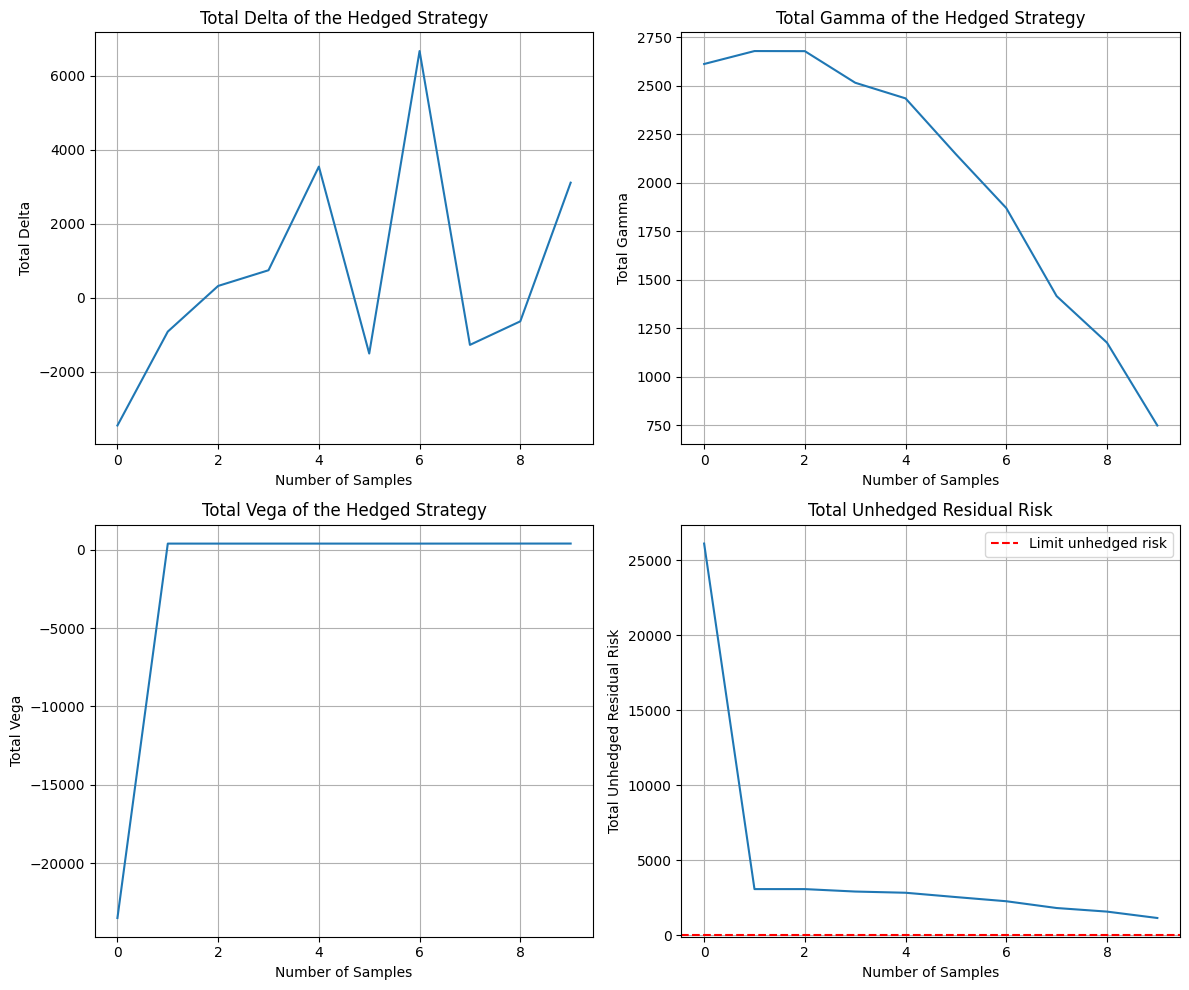

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a figure and a 2x2 grid of subplots

# Plot 1: Total delta of the hedged strategy
axs[0, 0].plot(delta_opt[1:])
axs[0, 0].set_title('Total Delta of the Hedged Strategy')
axs[0, 0].set_ylabel('Total Delta')
axs[0, 0].set_xlabel('Number of succesfull Samples')
axs[0, 0].grid()

#axs[0, 0].axhline(y=0, color='r', linestyle='--', label='Target Delta')
#axs[0, 0].legend()  # Display the legend to show the label

# Plot 4: Total unhedged residual risk
axs[1, 1].plot(unhedged_residual_risk_opt[1:])
axs[1, 1].set_title('Total Unhedged Residual Risk')
axs[1, 1].set_ylabel('Total Unhedged Residual Risk')
axs[1, 1].set_xlabel('Number of succesfull Samples')
axs[1, 1].grid()

axs[1, 1].axhline(y=limit_exposure, color='r', linestyle='--', label='Limit unhedged risk')
axs[1, 1].legend()  # Display the legend to show the label

# Plot 2: Total gamma of the hedged strategy
axs[0, 1].plot(gamma_opt[1:])
axs[0, 1].set_title('Total Gamma of the Hedged Strategy')
axs[0, 1].set_ylabel('Total Gamma')
axs[0, 1].set_xlabel('Number succesfull of Samples')
axs[0, 1].grid()

# Plot 3: Total vega of the hedged strategy
axs[1, 0].plot(vega_opt[1:])
axs[1, 0].set_title('Total Vega of the Hedged Strategy')
axs[1, 0].set_ylabel('Total Vega')
axs[1, 0].set_xlabel('Number of succesfull Samples')
axs[1, 0].grid()

plt.tight_layout()
plt.show()

# VaR CALCULATION

VaR calculation is performed by:

1) simulating the underlying stock price paths over a one-week horizon

2)calculating the payoff of each position in the portfolio based on the simulated stock prices at the end of the one-week period

3) aggregating the payoffs to determine the portfolio value and then calculate the VaR at the 95% confidence level

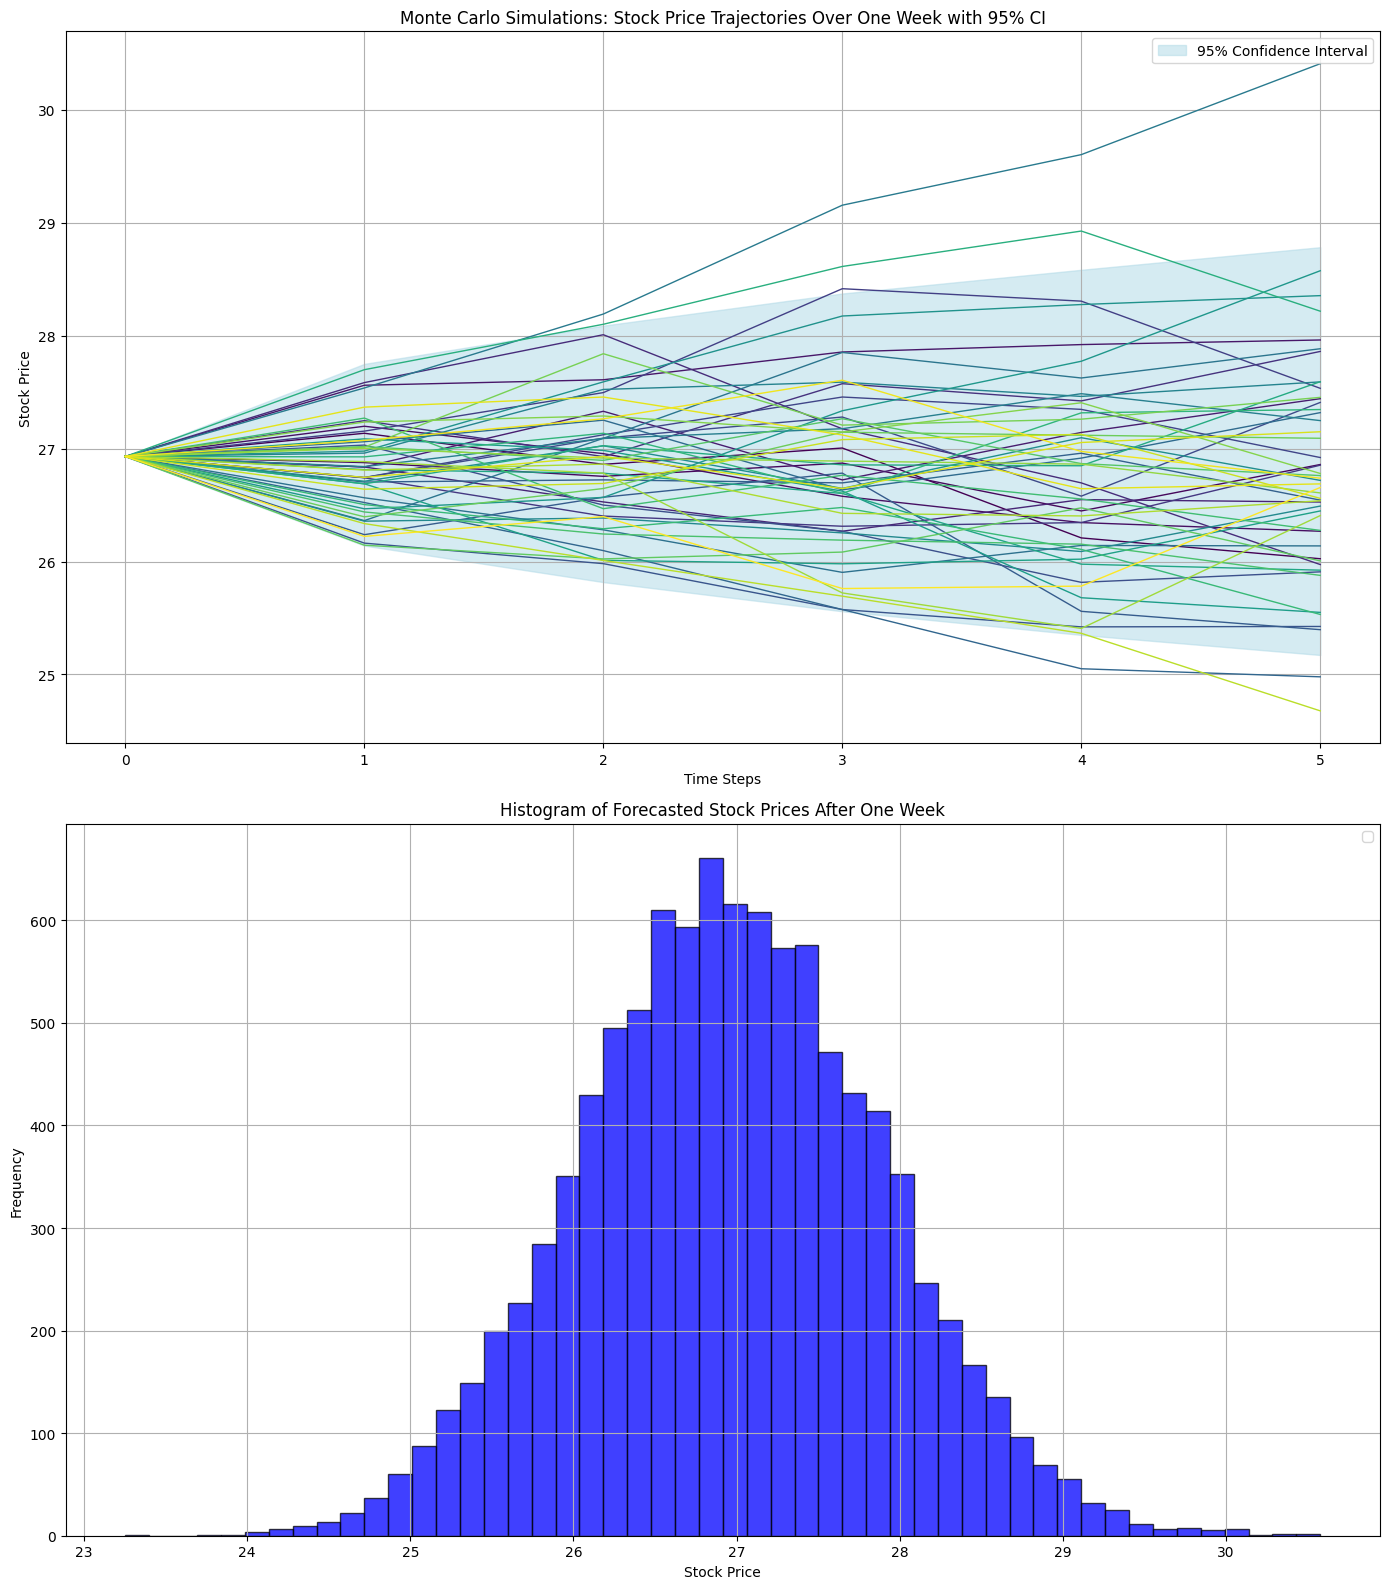

In [33]:
# Market parameters

S0 = 26.93               # stock price as of February 2nd
sigma = 0.2443           # implied volatility assumed from past data
r_st = 0.0523            # annualized risk-free rate according to T-Bill 1M
r_lt = 0.0534            # annualized risk-free rate according to T-Bill 3M
q = 0.0609                # dividend yield (Yahoo Finance)

r = r_st
T = 7/365                # 1 year time period
K = S0                   # assuming strike price equal stock price
T = 1/52  # One week in years
steps = 5  # Assuming 5 trading days in a week
simulations = 10000  # Number of Monte Carlo simulations

# Monte Carlo simulation to forecast stock prices
np.random.seed(42)  # For reproducibility
dt = T / steps
S_paths = np.zeros((steps + 1, simulations))
S_paths[0] = S0
for t in range(1, steps + 1):
    Z = np.random.standard_normal(simulations)
    S_paths[t] = S_paths[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

# Calculate the 2.5th and 97.5th percentiles for the 95% confidence interval
lower_bound = np.percentile(S_paths, 2.5, axis=1)
upper_bound = np.percentile(S_paths, 97.5, axis=1)

# Creating a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 16))

# Plotting 50 Monte Carlo simulation trajectories with a colormap
colors = plt.cm.viridis(np.linspace(0, 1, 50))
for i in range(50):
    axs[0].plot(S_paths[:, i], lw=1, color=colors[i])
axs[0].fill_between(range(steps + 1), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='95% Confidence Interval')
axs[0].set_title('Monte Carlo Simulations: Stock Price Trajectories Over One Week with 95% CI')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Stock Price')
axs[0].legend()
axs[0].grid(True)

# Histogram of the forecasted stock prices at the end of the week
final_prices = S_paths[-1]
confidence_left_level = np.percentile(final_prices, 5)
axs[1].hist(final_prices, bins=50, alpha=0.75, color='blue', edgecolor='black')
#axs[1].axvline(confidence_left_level, color='red', linestyle='dotted', linewidth=2, label='95% Confidence Level')
axs[1].set_title('Histogram of Forecasted Stock Prices After One Week')
axs[1].set_xlabel('Stock Price')
axs[1].set_ylabel('Frequency')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Price trading strategy -10576.670187789821
Price hedging strategy 9464.65
Price total strategy -1112.0201877898216
Price Delta Hedging -83761.99592013103
Price TOTAL (w delta hedging) Strategy -84874.01610792085


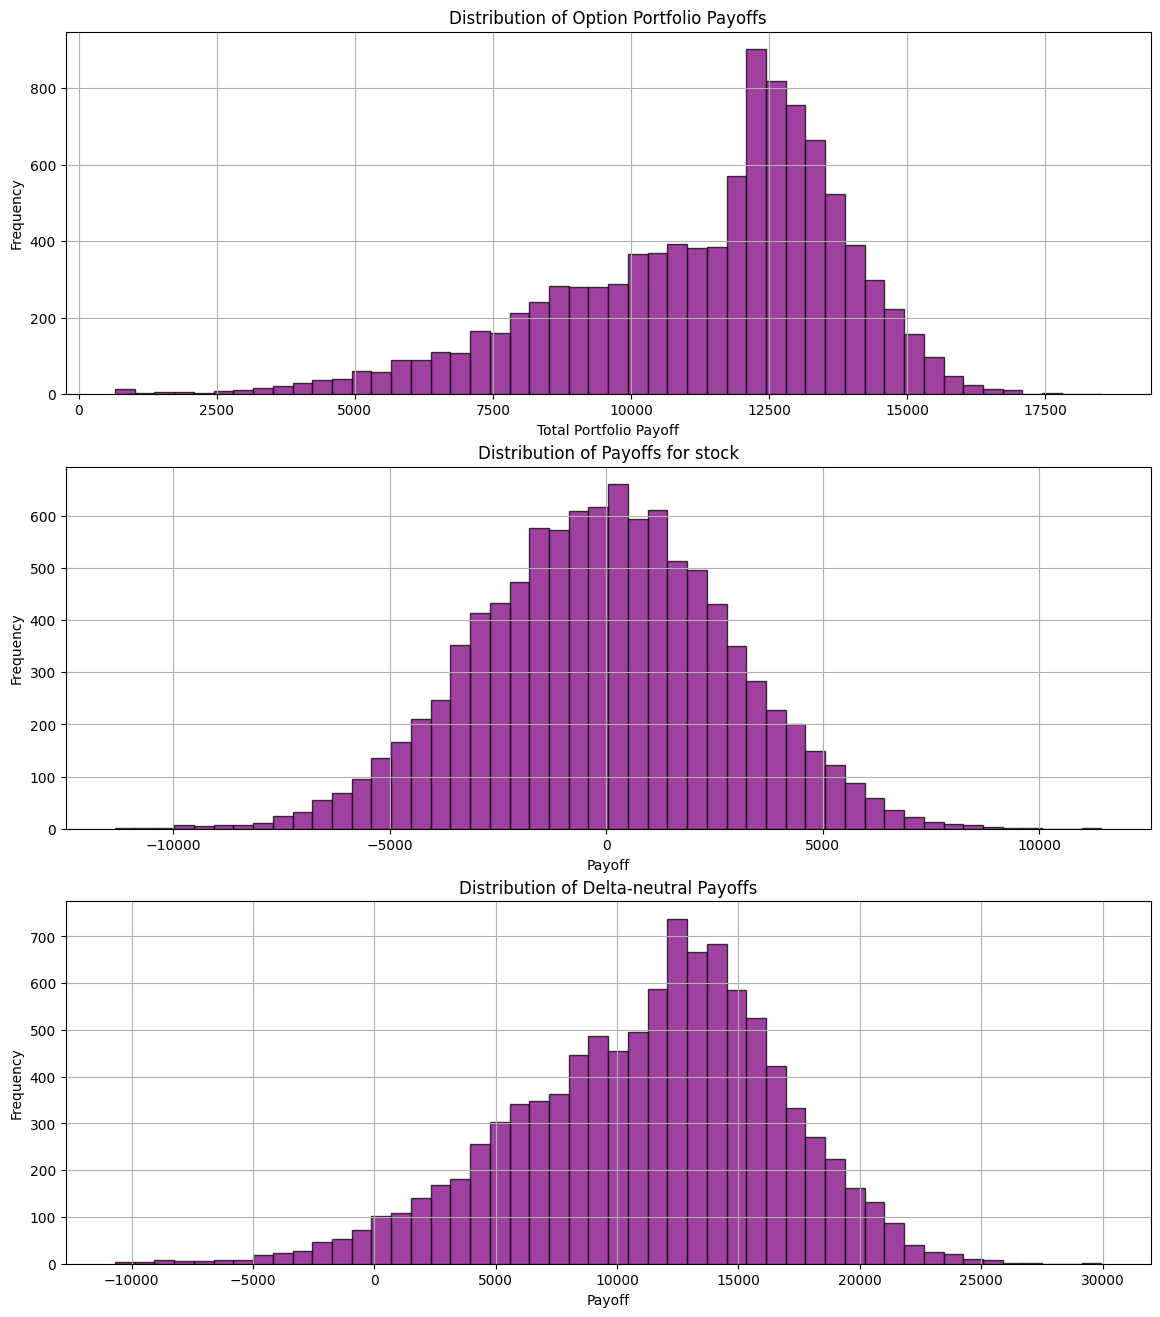

In [35]:
# Initialize an array to store the aggregated payoffs
total_portfolio_payoffs = np.zeros(len(final_prices))

# Iterate over each option to calculate and aggregate payoffs
for index, row in total_strategy.iterrows():
    units = row['Number of units']
    option_type = row['Option type']
    strike_price = row['Strike price (K)']

    # Calculate the payoff for each option type
    if option_type == 'Call':
        option_payoffs = units * np.maximum(final_prices - strike_price, 0)
    else:  # Option type is 'Put'
        option_payoffs = units * np.maximum(strike_price - final_prices, 0)

    # Aggregate the payoffs to the total portfolio payoff
    total_portfolio_payoffs += option_payoffs


fig, axs = plt.subplots(3, 1, figsize=(14, 16))


# Plotting the distribution of total portfolio payoffs
axs[0].hist(total_portfolio_payoffs, bins=50, alpha=0.75, color='purple', edgecolor='black')
axs[0].set_title('Distribution of Option Portfolio Payoffs')
axs[0].set_xlabel('Total Portfolio Payoff')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

stock_payoff = (final_prices - S0) * (-delta_strategy)
axs[1].hist(stock_payoff, bins=50, alpha=0.75, color='purple', edgecolor='black')
axs[1].set_title('Distribution of Payoffs for stock')
axs[1].set_xlabel('Payoff')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

final_payoff = total_portfolio_payoffs + stock_payoff



axs[2].hist(final_payoff, bins=50, alpha=0.75, color='purple', edgecolor='black')
axs[2].set_title('Distribution of Delta-neutral Payoffs')
axs[2].set_xlabel('Payoff')
axs[2].set_ylabel('Frequency')
axs[2].grid(True)

print("Price trading strategy", str(price_ts))
print("Price hedging strategy", str(price_hs_opt))
print("Price total strategy", str(price_ts+price_hs_opt))
print("Price Delta Hedging", str(-delta_strategy * S0))
print("Price TOTAL (w delta hedging) Strategy", str((-delta_strategy * S0)+price_ts+price_hs_opt))

plt.show()

The 95% VaR for the one-week horizon of option portfolio is 1574.14


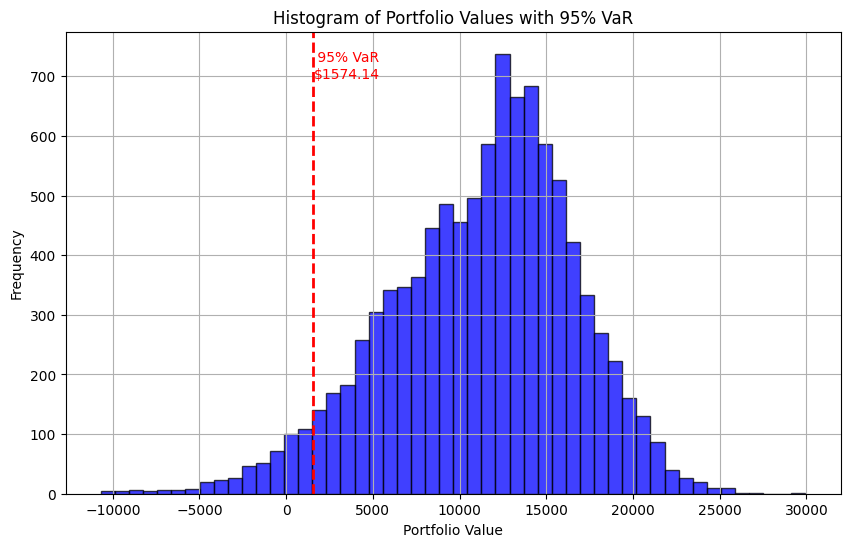

In [36]:
# Compute VaR
VaR_95 = np.percentile(final_payoff, 5)  # 5th percentile (left-tail measure)

print('The 95% VaR for the one-week horizon of option portfolio is', str(round(VaR_95, 2)))

# Plot histogram of portfolio values
plt.figure(figsize=(10, 6))
plt.hist(final_payoff, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(VaR_95, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogram of Portfolio Values with 95% VaR')
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.text(VaR_95, plt.ylim()[1]*0.9, f' 95% VaR\n${VaR_95:.2f}', color = 'red')

plt.grid(True)
plt.show()



**Sensitivity and Stress Analysis**

How does the above computed perfolio and its corresponding greeks change with a change in the volatility regime and strong movements in the underlying.


In [41]:
# Below are the input parameters for the sensitivity analysis S1 = Scenario1 , S2 = Scenario2, etc.
#Scenario 1: Underlying moves my 1%
#Scenario 2: Underlying moves my 10%
#Scenario 3: Underlying moves my -10%
#Scenario 4: volaility moves by 1%
#Scenario 5: volaility moves by 20%
#Scenario 6: volaility moves by - 20%

stress_strategy = total_strategy.copy()

list_sens_mkt = [1, 1.01, 1.1, 0.9, 1, 1, 1, 1, 0.7673, 0.689, 1.255, 1.08]         #market sensitivity and stress scenarios
list_sens_vol = [1, 1,1,1, 1.01, 1.2, 0.81, 2.41,3.23,1.282, 1.15]                  #volatility sensitivity and stress scenarios



for i in zip(list_sens_mkt, list_sens_vol):
    S_stress = S0*i[0]
    sigma_stress = sigma*i[0]
    col_val = []


    for index, row in stress_strategy.iterrows():
      units = row['Number of units']
      K = row['Strike price (K)']
      T = row['Time to expiration (T)']
      option_type = row['Option type'].lower()

      value_option = units*BSCallOptionMC(S_stress, K, r, sigma_stress, q, T, nSim)[0,0] if option_type == 'call' else units*BSPutOptionMC(S_stress, K, r, sigma_stress, q, T, nSim)[0,0]
      col_val.append(value_option)

    stress_strategy['S= '+str(np.round(S_stress,2))+' Sigma= '+str(np.round(sigma_stress,2))] = np.array(col_val)

stress_strategy.to_excel('total_strategy_stress.xlsx', index=False)
stress_strategy


,Number of units,Option type,Strike price (K),Time to expiration (T),Price,Delta,Gamma,Vega,S= 26.93 Sigma= 0.24,S= 27.2 Sigma= 0.25,S= 29.62 Sigma= 0.27,S= 24.24 Sigma= 0.22,S= 20.66 Sigma= 0.19,S= 18.55 Sigma= 0.17,S= 33.8 Sigma= 0.31
0,2500.0,Put,25.5,0.019178,0.020239,-0.052042,0.116837,0.396993,51.381791,25.939409,0.022305,3202.064430,12088.625331,17354.591666,0.000000
1,2500.0,Put,26.0,0.019178,0.069477,-0.146496,0.251799,0.855570,174.971978,99.824890,0.151867,4419.227879,13337.870901,18602.862102,0.000000
2,2500.0,Put,26.5,0.019178,0.186789,-0.312477,0.388301,1.319379,468.290189,295.931685,1.025278,5661.064794,14584.715768,19851.804055,0.000000
3,2500.0,Put,27.0,0.019178,0.402402,-0.525176,0.436447,1.482972,1005.167838,697.508176,5.543996,6908.407483,15835.329845,21099.233791,0.000000
4,2500.0,Put,27.5,0.019178,0.722119,-0.727242,0.363763,1.236005,1808.326247,1363.917738,22.761624,8162.580781,17080.055124,22348.499800,0.002948
5,-2500.0,Put,25.5,0.246575,0.685426,-0.305611,0.106416,4.648932,-1724.075780,-1550.288257,-613.688549,-4596.340651,-12062.130489,-17229.216453,-143.766773
6,-2500.0,Put,26.0,0.246575,0.875975,-0.363272,0.113728,4.968363,-2200.169411,-1995.530146,-817.056747,-5499.813524,-13285.166279,-18475.645564,-197.588186
7,-2500.0,Put,26.5,0.246575,1.094764,-0.422925,0.118404,5.172639,-2746.202208,-2507.310532,-1071.310825,-6473.297547,-14515.305837,-19699.268131,-271.733217
8,-2500.0,Put,27.0,0.246575,1.349107,-0.483112,0.120262,5.253812,-3376.121226,-3094.959835,-1371.930197,-7518.437572,-15755.584271,-20942.876421,-363.557589
9,-2500.0,Put,27.5,0.246575,1.626423,-0.542421,0.119327,5.212952,-4082.924537,-3754.065936,-1743.754877,-8580.854075,-16989.676220,-22170.959734,-475.306969


In [38]:
stress_strategy.columns

for col in stress_strategy.columns[9:]:  # Skip the first column
    stress_strategy[col] = stress_strategy['S= 26.93 Sigma= 0.24'] - stress_strategy[col]

# Show the updated DataFrame
print(stress_strategy)

    Number of units Option type  Strike price (K)  Time to expiration (T)  \
0            2500.0         Put              25.5                0.019178   
1            2500.0         Put              26.0                0.019178   
2            2500.0         Put              26.5                0.019178   
3            2500.0         Put              27.0                0.019178   
4            2500.0         Put              27.5                0.019178   
5           -2500.0         Put              25.5                0.246575   
6           -2500.0         Put              26.0                0.246575   
7           -2500.0         Put              26.5                0.246575   
8           -2500.0         Put              27.0                0.246575   
9           -2500.0         Put              27.5                0.246575   
10            -17.0        call              40.0                0.024658   
11           1671.0        call              30.0                0.619178   

In [39]:
stress_pf_value = stress_strategy
# Sum each "S=" column across all rows
s_column_sums = stress_pf_value.filter(regex='^S=').sum()

# Create a new DataFrame from these sums
sensitivity_portfolio_values = s_column_sums.to_frame().transpose()

sensitivity_portfolio_values

,S= 26.93 Sigma= 0.24,S= 20.66 Sigma= 0.19,S= 18.55 Sigma= 0.17,S= 33.8 Sigma= 0.31,S= 29.08 Sigma= 0.26
0,-4783.449743,5677.714102,8940.506143,-25080.378474,-8321.222859
